# Unsupervised Learning (Matrix Factorization)

## Setup

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import itertools
import numpy as np

### Data Setup

In [2]:
# Read dataset and create training an testing datasets
training_set = pd.read_csv('../Data/train.csv')
training_set = training_set.drop(columns=["id"])

In [3]:
feature_data = training_set.drop(columns=["defects"])

indexes = training_set["defects"].values

true_data = training_set[training_set["defects"].values == True]
false_data = training_set[training_set["defects"].values == False]

true_feature_data = true_data.drop(columns=["defects"])
false_feature_data = false_data.drop(columns=["defects"])

true_train_proportion = 0.5
false_train_proportion = true_train_proportion * len(true_feature_data) / len(false_feature_data)

true_X_train, true_X_validation, true_Y_train, true_Y_validation = train_test_split(true_feature_data, true_data["defects"], test_size=(1-true_train_proportion))
false_X_train, false_X_validation, false_Y_train, false_Y_validation = train_test_split(false_feature_data, false_data["defects"], test_size=(1-false_train_proportion))

X_train = pd.concat([true_X_train, false_X_train])
X_validation = pd.concat([true_X_validation, false_X_validation])
Y_train = pd.concat([true_Y_train, false_Y_train])
Y_validation = pd.concat([true_Y_validation, false_Y_validation])

## Model Creation

In [4]:
n_components=2
pca = PCA(n_components=n_components)
pca.fit(X_train) 
training_features = pca.transform(X_train)

In [5]:
def replace_set_labels(label_set, new_labels, old_labels):
    for i in range(len(old_labels)):
        label_set = [new_labels[i] if item == old_labels[i] else item for item in label_set]
    return label_set

def label_permute_compare(ytdf,yp,labels = [True, False]):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    
    perms = list(set(itertools.permutations(labels)))
    
    best_arr = []
    best_acc = -1
    
    options = np.unique(ytdf)

    for perm in perms:
        iter_arr = replace_set_labels(yp.copy(), perm, options)
            
        equal_values = iter_arr == ytdf.values
        iter_acc = np.count_nonzero(equal_values == True)/len(equal_values)
        
        if iter_acc > best_acc:
            best_arr = perm
            best_acc = iter_acc

    return [best_arr, best_acc]

In [6]:
training_predictions = pd.DataFrame(training_features).idxmax(axis=1)
extracted_topics, acc = label_permute_compare(Y_train, training_predictions)
print(extracted_topics, acc)

(True, False) 0.5


In [7]:
def calculate_probabilities(predictions):

    feature_predictions = predictions.drop(columns="Prediction")

    max_values = feature_predictions.max(axis=1)
    min_values = feature_predictions.min(axis=1)

    probabilities = (max_values-min_values) / (abs(max_values) + abs(min_values))
    probabilities = abs(1 - probabilities - predictions["Prediction"])
    
    return probabilities



In [8]:
# Transform the TF-IDF: nmf_features
testing_features = pca.transform(X_validation)

# Convert testing features into a DataFrame
testing_predictions = pd.DataFrame(testing_features, columns=extracted_topics)
testing_predictions.insert(2, "Prediction", testing_predictions.idxmax(axis=1), True)
testing_predictions.insert(3, "Probability", calculate_probabilities(testing_predictions), True)
# Print Predictions
testing_predictions


,True,False,Prediction,Probability
0,-31623.668924,-535.257483,False,0.033288
1,-24711.499570,-391.340771,False,0.031179
2,-33320.765921,-572.071339,False,0.033758
3,28994.379590,620.117238,True,0.958121
4,-19061.556282,-279.660623,False,0.028919
...,...,...,...,...
78694,-24391.643299,-388.409096,False,0.031349
78695,-25665.862353,-406.634356,False,0.031193
78696,-32677.176417,-554.259152,False,0.033358
78697,-33144.565516,-565.872765,False,0.033573


In [9]:
conf_matrix = confusion_matrix(list(Y_validation), testing_predictions["Prediction"], labels=[False, True])

recall_true = conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1])
precision_true = conf_matrix[1][1] / (conf_matrix[0][1] + conf_matrix[1][1])
F1_true = 2 * ( (precision_true * recall_true) / (precision_true + recall_true) )

correct_vals = conf_matrix[0][0] + conf_matrix[1][1]
incorrect_vals = conf_matrix[0][1] + conf_matrix[1][0]
accuracy = correct_vals / (correct_vals + incorrect_vals)

print("Correctly predicted labelss: ", correct_vals)
print("Incorrectly predicted labelss: ", incorrect_vals)
print("Model's accuracy: ", accuracy)
print("Model's recall: ", recall_true)
print("Model's precision: ", precision_true)
print("Model's F1 score: ", F1_true)

Correctly predicted labelss:  66815
Incorrectly predicted labelss:  11884
Model's accuracy:  0.8489942693045655
Model's recall:  0.246704821366632
Model's precision:  0.47087057265806026
Model's F1 score:  0.32377375668601344


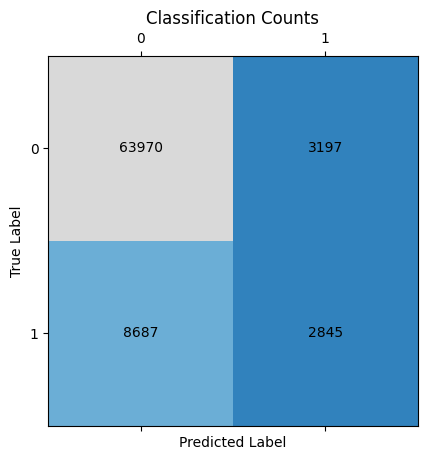

In [10]:
# Plot confusion Matrix
fig, ax = plt.subplots()
ax.matshow(conf_matrix, cmap='tab20c')

# Print classification counts within matrix boxes
for i in range(len(conf_matrix)):
   for j in range(len(conf_matrix[0])):
      c = conf_matrix[j, i]
      ax.text(i, j, str(c), va='center', ha='center')

# Set plot axis titles and show plot
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Classification Counts')
plt.show()

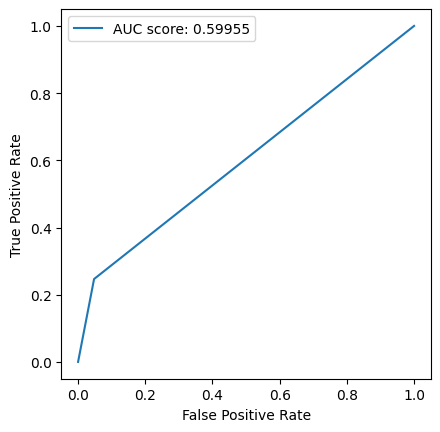

In [11]:

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Calculate scores for testing dataset
fpr, tpr, thresholds = roc_curve(list(Y_validation), testing_predictions["Prediction"])

# Calculate AUC score
auc_score = roc_auc_score(list(Y_validation), testing_predictions["Prediction"])

# Print ROC plot
plt.plot(fpr, tpr,)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(["AUC score: " + str(round(auc_score, 5))], loc="best")
plt.show()

## Kaggle Testing

In [12]:
testing_set = pd.read_csv('../Data/test.csv')
test = testing_set.drop(columns=["id"])

# Transform the TF-IDF: nmf_features
testing_features = pca.transform(test)

# Convert testing features into a DataFrame
test_predictions = pd.DataFrame(testing_features, columns=extracted_topics)
test_predictions.insert(2, "Prediction", test_predictions.idxmax(axis=1), True)
test_predictions.insert(3, "Probability", calculate_probabilities(test_predictions), True)
# Print Predictions
test_predictions


,True,False,Prediction,Probability
0,-10649.698845,-123.563358,False,0.022939
1,-18815.841034,-280.158462,False,0.029342
2,83013.743707,1712.227260,True,0.959582
3,-17159.687714,-241.170976,False,0.027719
4,-30691.696710,-514.163102,False,0.032953
...,...,...,...,...
67837,-24693.900576,-386.265243,False,0.030802
67838,-32257.724445,-545.991855,False,0.033288
67839,-31156.811900,-522.585430,False,0.032992
67840,-31198.669348,-524.337532,False,0.033057


In [13]:
results = pd.DataFrame(testing_set["id"].copy())
results["defects"] = test_predictions["Probability"]

print(results.head())
results.to_csv("../Data/results.csv", index=False)

       id   defects
0  101763  0.022939
1  101764  0.029342
2  101765  0.959582
3  101766  0.027719
4  101767  0.032953


## References

* [Binary Classification with a Software Defects Dataset](https://www.kaggle.com/competitions/playground-series-s3e23/code)
* [Software Metrics Glossary](http://www.mccabe.com/iq_research_metrics.htm)
* [Software Engineering | Halstead’s Software Metrics](https://www.geeksforgeeks.org/software-engineering-halsteads-software-metrics/)